In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import ale_py
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make("ALE/Pong-v5") 
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

device

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


device(type='mps')

In [3]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (torch.FloatTensor(np.float32(state)), 
                torch.LongTensor(action), 
                torch.FloatTensor(reward), 
                torch.FloatTensor(np.float32(next_state)),
                torch.BoolTensor(done))
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_shape, n_actions, device="cpu"):
        self.device = device
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        self.policy_net = DQN(state_shape, n_actions).to(device)
        self.target_net = DQN(state_shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.memory = ReplayBuffer(100000)
        
        self.batch_size = 32
        self.gamma = 0.99
        self.eps_start = 1.0
        self.eps_end = 0.02
        self.eps_decay = 100000
        self.target_update = 1000
        self.steps_done = 0
        
    def select_action(self, state):
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        
        if random.random() > eps_threshold:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()
        else:
            return random.randrange(self.n_actions)
    
    def select_greedy_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.max(1)[1].item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        
        state_batch = state_batch.to(self.device)
        action_batch = action_batch.to(self.device)
        reward_batch = reward_batch.to(self.device)
        next_state_batch = next_state_batch.to(self.device)
        done_batch = done_batch.to(self.device)
        
        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        with torch.no_grad():
            next_state_values = self.target_net(next_state_batch).max(1)[0]
            next_state_values[done_batch] = 0.0
            expected_q_values = reward_batch + self.gamma * next_state_values
        
        loss = nn.SmoothL1Loss()(current_q_values.squeeze(), expected_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        return loss.item()

def preprocess_frame(frame):
    frame = frame[35:195]  # Crop
    frame = frame[::2, ::2]  # Downsample
    frame = frame.mean(axis=2)  # Convert to grayscale
    frame = frame.astype(np.float32) / 255.0
    return frame

def train(agent, env, num_episodes=1000):
    frame_stack = deque(maxlen=4)
    losses = []
    
    for episode in range(num_episodes):
        frame, _ = env.reset()
        frame = preprocess_frame(frame)
        
        for _ in range(4):
            frame_stack.append(frame)
        
        total_reward = 0
        done = False
        truncated = False
        
        while not (done or truncated):
            state = np.array(frame_stack)
            action = agent.select_action(state)
            
            next_frame, reward, done, truncated, _ = env.step(action)
            next_frame = preprocess_frame(next_frame)
            frame_stack.append(next_frame)
            next_state = np.array(frame_stack)
            
            agent.memory.push(state, action, reward, next_state, bool(done))
            
            if len(agent.memory) >= agent.batch_size:
                loss = agent.optimize_model()
            
            total_reward += reward
            
            if agent.steps_done % agent.target_update == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        print(f"Episode {episode}, Total Reward: {total_reward}, Steps: {agent.steps_done}")
        losses.append(total_reward)
        
        # Save model periodically
        if episode % 100 == 99:
            torch.save(agent.policy_net.state_dict(), f"pong_dqn_episode_{episode}.pth")

        if episode == num_episodes - 1:
            torch.save(agent.policy_net.state_dict(), f"pong_dqn_episode_end.pth")

    return agent, losses

In [4]:
state_shape = (4, 80, 80)  # 4 frames stacked, 80x80 each
n_actions = env.action_space.n

agent = DQNAgent(state_shape, n_actions, device)

In [5]:
# load the model
if os.path.exists("pong_dqn_episode_end.pth"):
    agent.policy_net.load_state_dict(torch.load("pong_dqn_episode_end.pth"))
    losses = np.load("losses.npy")
else:
    agent, losses = train(agent, env, num_episodes=1000)
    np.save("losses.npy", np.array(losses))

In [6]:
def play_game(agent, env):
    frame_stack = deque(maxlen=4)
    frame, _ = env.reset()
    frame = preprocess_frame(frame)
    
    for _ in range(4):
        frame_stack.append(frame)
    
    total_reward = 0
    done = False
    truncated = False
    
    while not (done or truncated):
        state = np.array(frame_stack)
        action = agent.select_greedy_action(state)
        
        next_frame, reward, done, truncated, _ = env.step(action)
        next_frame = preprocess_frame(next_frame)
        frame_stack.append(next_frame)
        
        total_reward += reward
    
    return total_reward

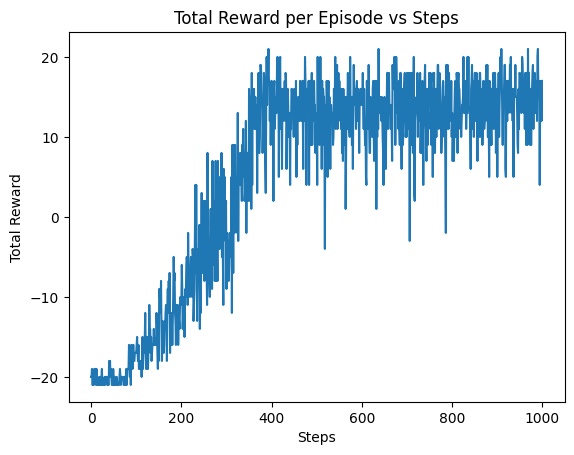

In [7]:
# plot the losses
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode vs Steps")
plt.show()

In [8]:
def display_game(agent):
    from IPython import display
    plt.ion()


    frame_stack = deque(maxlen=4)
    frame, _ = env.reset()
    frame = preprocess_frame(frame)
    
    for _ in range(4):
        frame_stack.append(frame)
    
    total_reward = 0
    done = False
    truncated = False

    
    while not (done or truncated):
        state = np.array(frame_stack)
        action = agent.select_greedy_action(state)
        
        next_frame, reward, done, truncated, _ = env.step(action)

        plt.figure(figsize=(8, 8))
        plt.imshow(next_frame)
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()
        
        next_frame = preprocess_frame(next_frame)
        frame_stack.append(next_frame)
        
        total_reward += reward

        print(f"Total Reward: {total_reward}")

    plt.ioff()

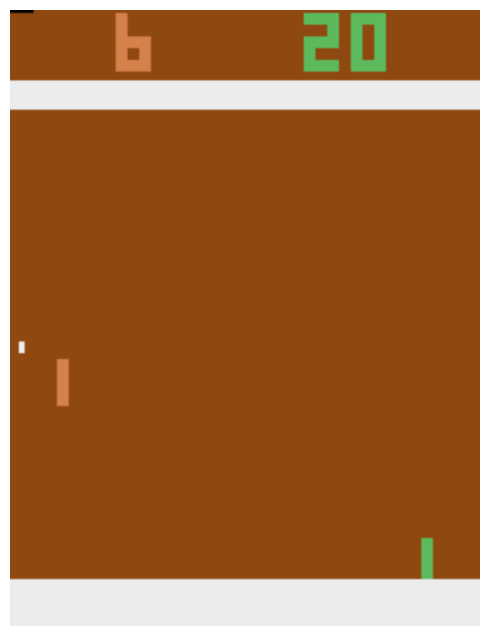

Total Reward: 15.0


In [9]:
display_game(agent)